### Imports

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import os
plt.style.use('fivethirtyeight')

### Define some constants 

In [74]:
# images have 3 channels and are 256 x 256 pixels
project_dir = './data/potato_data'
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

### Load the images into a keras dataset

In [75]:
# load images
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    project_dir,
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [76]:
for image_batch, _ in dataset.take(1):
    print(image_batch.numpy().shape)

(32, 256, 256, 3)


In [77]:
# check the difference classes
class_names = dataset.class_names
print(class_names)
n_classes = len(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


### Explore Dataset

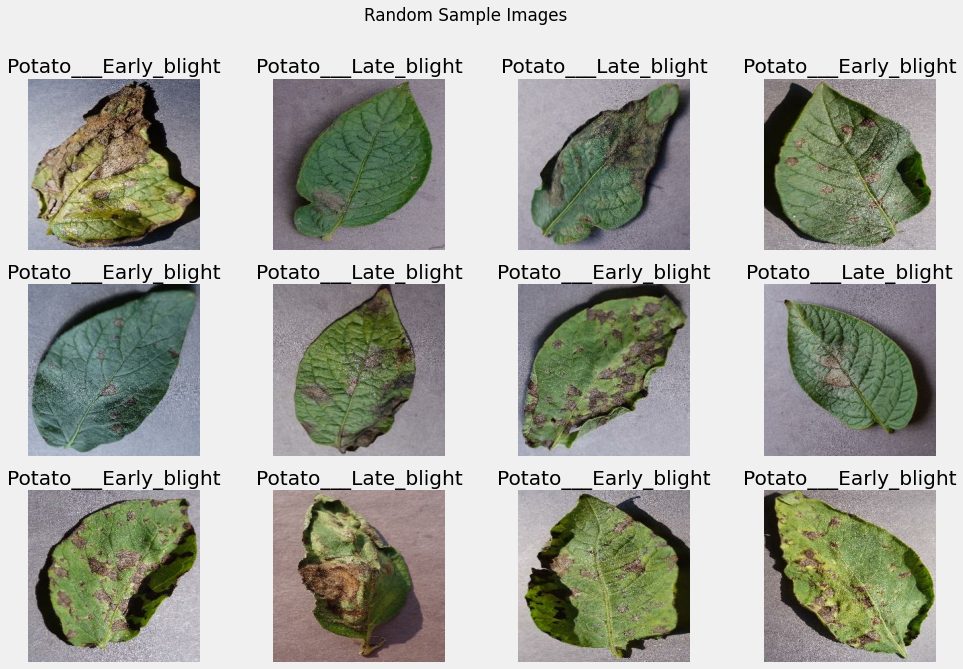

In [78]:
plt.figure(figsize = (15, 10))
plt.suptitle('Random Sample Images')
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.grid(False)
        plt.axis(False)

### Split dataset into training, validation, and testing datasets

In [79]:
# split dataset 80 train / 10 val / 10 test
def train_val_test_split_tf(dataset, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
    ds_size = int(len(dataset))
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=0)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [80]:
train_ds, val_ds, test_ds = train_val_test_split_tf(dataset)

In [81]:
# fetching and caching to optimize performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Preprocessing Layers

In [82]:
# resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [83]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Build the model

In [84]:
model = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape = INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=INPUT_SHAPE)